In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


#load all data
Data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
oil=pd.read_csv('oil.csv')
stores=pd.read_csv('stores.csv')
transactions=pd.read_csv('transactions.csv')
holidays=pd.read_csv('holidays_events.csv')


In [2]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


# predict/forecast sales of products

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
Data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [6]:
train = pd.read_csv("train.csv",usecols=['store_nbr', 'family', 'date', 'sales'], parse_dates=["date"],
                       dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    infer_datetime_format=True
                   )
#train = train.set_index("date").to_period("D")
train['date'] = train.date.dt.to_period('D')


In [7]:
train

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000000
1,2013-01-01,1,BABY CARE,0.000000
2,2013-01-01,1,BEAUTY,0.000000
3,2013-01-01,1,BEVERAGES,0.000000
4,2013-01-01,1,BOOKS,0.000000
...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996
3000884,2017-08-15,9,PREPARED FOODS,154.552994
3000885,2017-08-15,9,PRODUCE,2419.729004
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000


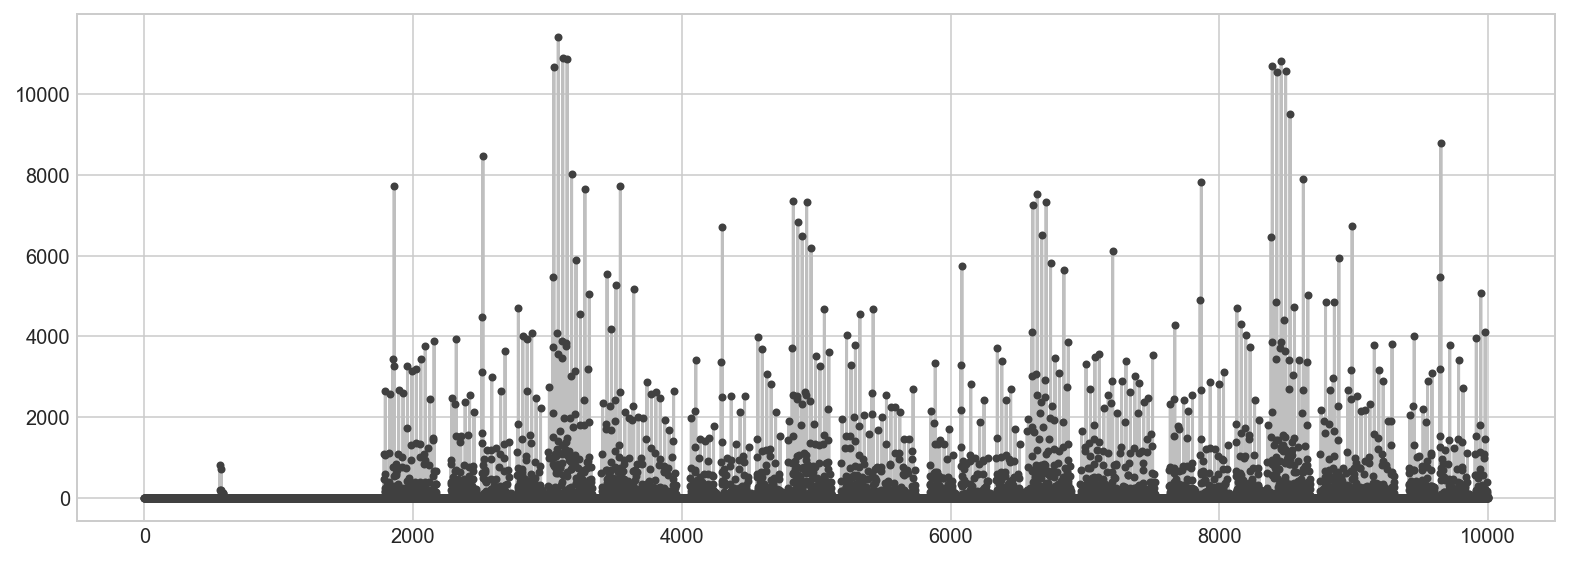

In [8]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

ax = train.sales[:10000].plot( **plot_params)

seasonality

In [9]:
train=train.set_index(['store_nbr', 'family', 'date']).sort_index()

In [10]:
train

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]

In [40]:
y = train.unstack(['store_nbr', 'family']).loc["2017"]
y

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...           

In [41]:
# Create training data
fourier = CalendarFourier(freq="A", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()



In [42]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.628763,-0.777597,0.977848,0.209315,-0.891981,0.452072,0.409356,-0.912375
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.642055,-0.766659,0.984474,0.175531,-0.867456,0.497513,0.345612,-0.938377
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,0.989932,0.141540,-0.840618,0.541628,0.280231,-0.959933


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [45]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,,
2017-07-01,1.0,182.0,0.0,0.0,0.0,0.0,0.0,1.0,0.025818,-0.999667,-0.051620,0.998667,0.077386,-0.997001,-0.103102,0.994671
2017-07-02,1.0,183.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008607,-0.999963,-0.017213,0.999852,0.025818,-0.999667,-0.034422,0.999407
2017-07-03,1.0,184.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.008607,-0.999963,0.017213,0.999852,-0.025818,-0.999667,0.034422,0.999407
2017-07-04,1.0,185.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.025818,-0.999667,0.051620,0.998667,-0.077386,-0.997001,0.103102,0.994671
2017-07-05,1.0,186.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.043022,-0.999074,0.085965,0.996298,-0.128748,-0.991677,0.171293,0.985220
2017-07-06,1.0,187.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.060213,-0.998186,0.120208,0.992749,-0.179767,-0.983709,0.238673,0.971100
2017-07-07,1.0,188.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.077386,-0.997001,0.154309,0.988023,-0.230306,-0.973118,0.304921,0.952378
2017-07-08,1.0,189.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.094537,-0.995521,0.188227,0.982126,-0.280231,-0.959933,0.369725,0.929141
2017-07-09,1.0,190.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.111659,-0.993747,0.221922,0.975065,-0.329408,-0.944188,0.432776,0.901502


# LinearRegression

In [19]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_train), index=y_train.index,columns=y_train.columns)
y_fore = pd.DataFrame(model.predict(X_test), index=y_test.index,columns=y_test.columns)

In [20]:
print("train error / mean_squared_error :{}".format(mean_squared_error(y_train,y_pred,squared=False)))
print("train error / r2_score :{}".format(r2_score(y_train,y_pred)))

print("val error / mean_squared_error :{}".format(mean_squared_error(y_test,y_fore,squared=False)))
print("val error / r2_score :{}".format(r2_score(y_test,y_fore)))



train error / mean_squared_error :106.18819828186037
train error / r2_score :0.39478256910593257
val error / mean_squared_error :6222.319584611458
val error / r2_score :-20043.923814249032


# XGboost

In [21]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_pred = pd.DataFrame(model.predict(X_train), index=y_train.index,columns=y_train.columns)
y_fore = pd.DataFrame(model.predict(X_test), index=y_test.index,columns=y_test.columns)

In [22]:
print("train error / mean_squared_error :{}".format(mean_squared_error(y_train,y_pred,squared=False)))
print("train error / r2_score :{}".format(r2_score(y_train,y_pred)))

print("val error / mean_squared_error :{}".format(mean_squared_error(y_test,y_fore,squared=False)))
print("val error / r2_score :{}".format(r2_score(y_test,y_fore)))



train error / mean_squared_error :0.7713063955307007
train error / r2_score :0.9589553980071652
val error / mean_squared_error :111.66429901123047
val error / r2_score :-0.5857703835748199


In [39]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)",NewYear
date,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.693281,-0.720667,0.999250,0.038722,-0.746972,0.664855,0.077386,-0.997001,False
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.705584,-0.708627,0.999991,0.004304,-0.711657,0.702527,0.008607,-0.999963,False
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.717677,-0.696376,0.999546,-0.030120,-0.674444,0.738326,-0.060213,-0.998186,False
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.729558,-0.683919,0.997917,-0.064508,-0.635432,0.772157,-0.128748,-0.991677,False
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,0.995105,-0.098820,-0.594727,0.803928,-0.196673,-0.980469,False
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.752667,-0.658402,0.991114,-0.133015,-0.552435,0.833556,-0.263665,-0.964614,False
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.763889,-0.645348,0.985948,-0.167052,-0.508671,0.860961,-0.329408,-0.944188,False
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.774884,-0.632103,0.979614,-0.200891,-0.463550,0.886071,-0.393590,-0.919286,False
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.785650,-0.618671,0.972118,-0.234491,-0.417194,0.908818,-0.455907,-0.890028,False


# Random forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error


In [47]:

model = RandomForestRegressor(random_state=1)

model.fit(X_train, y_train)


y_pred = pd.DataFrame(model.predict(X_train), index=y_train.index,columns=y_train.columns)
y_fore = pd.DataFrame(model.predict(X_test), index=y_test.index,columns=y_test.columns)


print("train error / mean_squared_log_error :{}".format(mean_squared_log_error(y_train,y_pred)))
print("train error / mean_absolute_error :{}".format(mean_absolute_error(y_train,y_pred)))


print("val error / mean_squared_log_error :{}".format(mean_squared_log_error(y_test,y_fore)))
print("val error / mean_absolute_error :{}".format(mean_absolute_error(y_test,y_fore)))


train error / mean_squared_log_error :0.15099590613155878
train error / mean_absolute_error :28.811498985295177
val error / mean_squared_log_error :0.24766199714536402
val error / mean_absolute_error :76.85576033512012


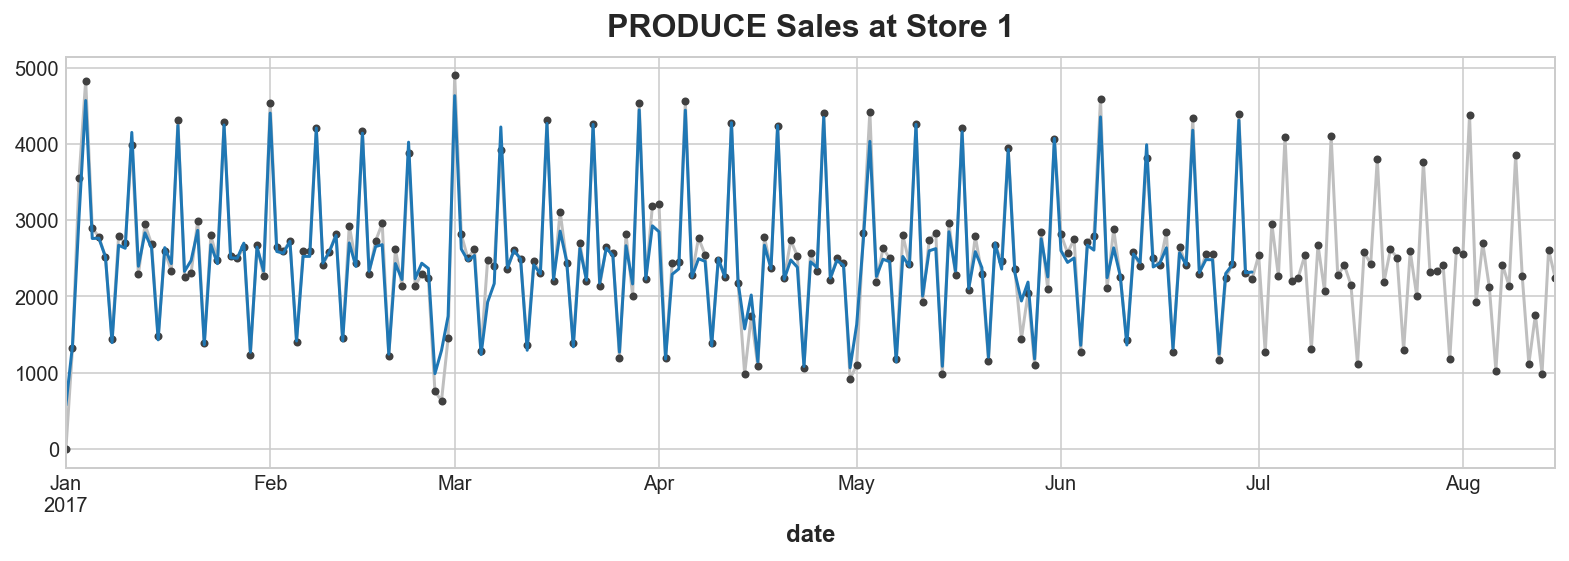

In [48]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [49]:
df_test = pd.read_csv('test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [50]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [51]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

In [52]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.693281,-0.720667,0.999250,0.038722,-0.746972,0.664855,0.077386,-0.997001
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.705584,-0.708627,0.999991,0.004304,-0.711657,0.702527,0.008607,-0.999963
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.717677,-0.696376,0.999546,-0.030120,-0.674444,0.738326,-0.060213,-0.998186
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.729558,-0.683919,0.997917,-0.064508,-0.635432,0.772157,-0.128748,-0.991677
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,0.995105,-0.098820,-0.594727,0.803928,-0.196673,-0.980469
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.752667,-0.658402,0.991114,-0.133015,-0.552435,0.833556,-0.263665,-0.964614
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.763889,-0.645348,0.985948,-0.167052,-0.508671,0.860961,-0.329408,-0.944188
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.774884,-0.632103,0.979614,-0.200891,-0.463550,0.886071,-0.393590,-0.919286
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.785650,-0.618671,0.972118,-0.234491,-0.417194,0.908818,-0.455907,-0.890028


In [53]:
X_test.shape

(16, 16)

In [54]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)


In [55]:
y_submit

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-16       3.28       0.0   3.63   2261.09  0.81   392.665601   
2017-08-17       2.72       0.0   2.25   1952.35  0.20   359.743512   
2017-08-18       5.39       0.0   2.68   2220.46  0.17   369.286312   
2017-08-19       5.17       0.0   4.99   2419.05  0.34   391.673091   
2017-08-20       2.03       0.0   2.06    976.91  0.17   165.944461   
2017-08-21       3.95       0.0   4.10   2131.44  0.31   362.378678   
2017-08-22       3.08       0.0   3.33   2255.39  0.53   356.911723   
2017-08-23       3.32       0.0   3.68   2219.58  0.71   377.870971   
2017-08-24       2.83       0.0   2.59   1934.44  0.21   365.289738   
2017-08-25       5.64       0.0   2.51   2156.39  0.19   355.922400   
2017-08-26       4.39       0.0   4.92   2333.61  0.24   388.174064   
2017-08-27       2.31       0.0   2.28    968.12  0.23   166.917399   
2017-08-28       3.32       0.0   3.32   1877.05  0.42   320.878028   
2017-08-29       2.71       0.0   3.02   2442.89  0.56   377.461615   
2017-08-30       3.85       0.0   4.96   2248.68  0.91   392.876846   
2017-08-31       2.95       0.0   2.06   2214.55  0.26   389.757324   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-08-16       18.27   821.82  791.68  138.679317  ...      2.19   
2017-08-17       17.31   652.02  673.90  113.233590  ...      2.88   
2017-08-18       22.45   713.31  772.61  157.226459  ...      3.30   
2017-08-19       11.04   611.61  780.21  143.972728  ...      4.34   
2017-08-20        3.92   235.38  324.86   63.098890  ...      4.80   
2017-08-21       13.41   606.21  686.33  122.976159  ...      2.62   
2017-08-22       14.82   744.51  716.15  126.569401  ...      3.26   
2017-08-23       14.55   848.66  805.36  135.818198  ...      3.09   
2017-08-24       19.10   664.48  679.61  113.943769  ...      2.84   
2017-08-25       23.30   706.39  756.33  155.846649  ...      3.74   
2017-08-26       12.76   608.52  778.24  139.048169  ...      4.59   
2017-08-27        4.71   241.44  315.32   60.907200  ...      4.73   
2017-08-28       12.15   532.61  619.54  111.655239  ...      2.81   
2017-08-29       14.93   801.28  751.85  140.205430  ...      2.37   
2017-08-30       17.84   885.55  812.41  140.356577  ...      3.61   
2017-08-31       16.87   788.11  715.86  122.127259  ...      2.11   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-16  296.871685        328.24         5.88                   11.13   
2017-08-17  490.219742        338.79         7.47                   10.47   
2017-08-18  283.418709        310.55         5.26                    8.45   
2017-08-19  383.297237        539.73        10.41                   13.88   
2017-08-20  379.070265        526.17         8.61                   12.27   
2017-08-21  323.424842        398.70         5.62                    9.79   
2017-08-22  332.965778        412.87         6.67                    9.97   
2017-08-23  296.891212        327.14         5.48                    8.89   
2017-08-24  481.523515        342.89         5.86                   10.07   
2017-08-25  290.887051        309.84         5.06                    8.21   
2017-08-26  403.119940        583.25         9.97                   14.35   
2017-08-27  387.480333        557.04   

In [56]:
y_submit = y_submit.stack(['store_nbr', 'family'])

In [57]:
y_submit

sales
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     3.280000
                     BABY CARE                      0.000000
                     BEAUTY                         3.630000
                     BEVERAGES                   2261.090000
                     BOOKS                          0.810000
...                                                      ...
2017-08-31 9         POULTRY                      329.145773
                     PREPARED FOODS               104.391109
                     PRODUCE                     1311.476666
                     SCHOOL AND OFFICE SUPPLIES     3.230000
                     SEAFOOD                       13.973330

[28512 rows x 1 columns]

In [58]:


y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

In [229]:
y_submit.id.values

array([3000888, 3000889, 3000890, ..., 3029397, 3029398, 3029399],
      dtype=int64)


y_submit.to_csv('submission.csv', index=False)